In [110]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
import pickle
from scipy import stats
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

from models import DeepConditionalModel, InvariantNetwork
from inn_utils import train_online_ml, compute_performance_metrics
from losses import maximum_mean_discrepancy
from process_models import simulate_diffusion, simulate_diffusion_params
from viz import (plot_true_est_scatter, plot_true_est_posterior, 
                 plot_losses, plot_sbc, plot_performance_metrics, plot_contraction)

In [2]:
tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

# Initialization 

In [4]:
def index_parameters(X_batch, theta_batch, indices):
    """
    Indexes only the relevant Levy parameters.
    """
    
    theta_batch = tf.gather(theta_batch, indices, axis=1)
    return X_batch, theta_batch

In [90]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}

parameter_bounds = {
        'v1': [0.0, 6.0],
        'v2': [-6.0, 0.0],
        'sv': [0.0, 0.0],
        'zr': [0.3, 0.7],
        'szr': [0.0, 0.0],
        'a': [0.6, 3.0],
        'ndt': [0.3, 1.0],
        'sndt': [0.0, 0.0],
        'alpha': [1.0, 2.0],
    }


# --- Training hyperparameters --- #
train = False
param_names = [r'$v_{1}$', r'$v_{2}$', r'$zr$', r'$a$', r'$t_{0}$', r'$\alpha$']
param_indices = [0, 1, 3, 5, 6, 8]
theta_dim = 6
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 32
summary_dim = 128
epochs = 100
iterations_per_epoch = 1000
n_test2 = 3
n_inv_blocks = 10
n_test = 300
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 4000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

In [6]:
data_generator = partial(simulate_diffusion, pbounds=parameter_bounds)
transform = partial(index_parameters, indices=param_indices)

## Create a test set

In [ ]:
# # For scatter
X_test, theta_test = simulate_diffusion(n_test, parameter_bounds, n_points=1000)
X_test, theta_test = transform(X_test, theta_test)

In [ ]:
# For density
X_test2, theta_test2 = simulate_diffusion(n_test2, parameter_bounds, n_points=1000)
X_test2, theta_test2 = transform(X_test2, theta_test2)

## Create networks

In [91]:
summary_net = InvariantNetwork(summary_dim, n_equiv=3)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

##  Checkpoint Manager

In [92]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/levy', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/levy\ckpt-final


## Plot performance of untrained networks

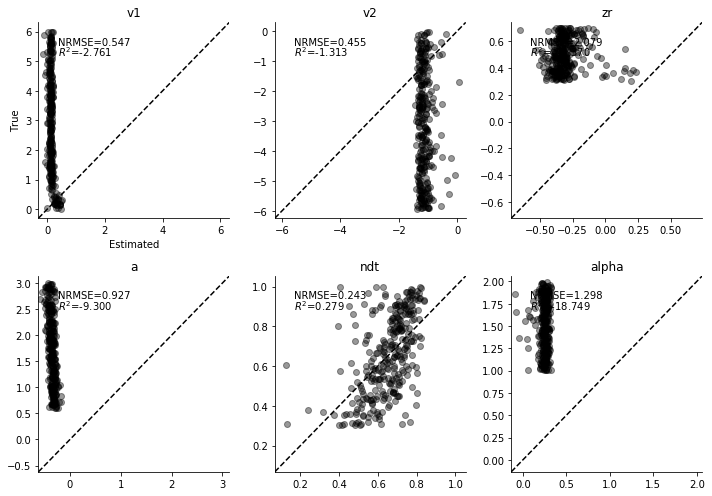

In [32]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 7))

# Train the model

In [14]:
%%time
if train:
    for ep in range(1, epochs+1):
        with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
            losses = train_online_ml(model, optimizer, data_generator, iterations_per_epoch, 
                                batch_size, iterations_per_epoch, p_bar, clip_value=clip_value, 
                                global_step=global_step, transform=transform, ckpt_name='Levy_{}'.format(ep))
            # Plot stuff
            plot_losses(losses, figsize=(10, 4))
            plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 7))
            plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 4))

            # Store checkpoint
            manager.save()

Wall time: 0 ns


# Evaluate the trained model

## Posterior means (recovery)

In [ ]:
%%time
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, 
                      param_names, filename=None, figsize=(10, 6))

## Full posterior (visual inspection)

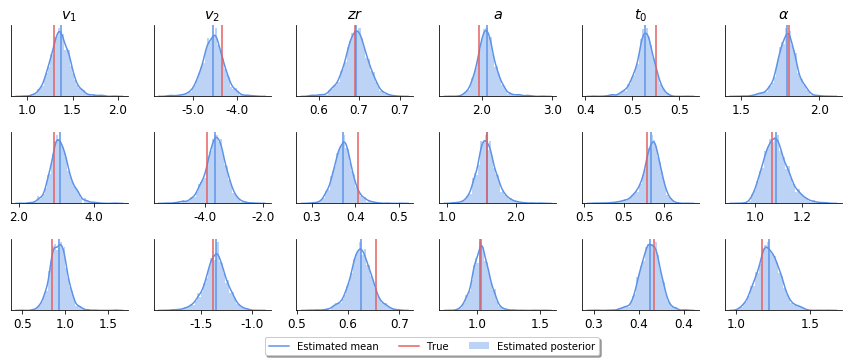

Wall time: 6.79 s


In [87]:
%%time
plot_true_est_posterior(model, n_samples=n_samples_posterior, param_names=param_names, filename='Levy',
                        X_test=X_test2, theta_test=theta_test2, figsize=(12, 5), tight=True)

## Simulation-based calibration

In [43]:
# For sbc
X_sbc, theta_sbc = simulate_diffusion(5000, parameter_bounds, n_points=1000)
X_sbc, theta_sbc = transform(X_sbc, theta_sbc)

In [ ]:
# Make sure GPU memory does not blow off
theta_samples = np.concatenate([model.sample(x, n_samples=250, to_numpy=True)
                                for x in tf.split(X_sbc, 20, 0)], axis=1)

In [ ]:
%%time
plot_sbc(theta_samples, theta_sbc, param_names, figsize=(12, 6), bins=50, filename='levy')

## Recovery over all N

In [236]:
n_points_grid=np.arange(100, 1001, 10)

metrics = compute_performance_metrics(model, 
                    n_points_grid, 
                    param_names=param_names, 
                    simulate_fun=data_generator,
                    n_sim=10, 
                    n_test=300, 
                    n_samples=2000, 
                    transform=transform)

In [237]:
pickle.dump(metrics, open('results/metrics_levy.pkl', 'wb+'))

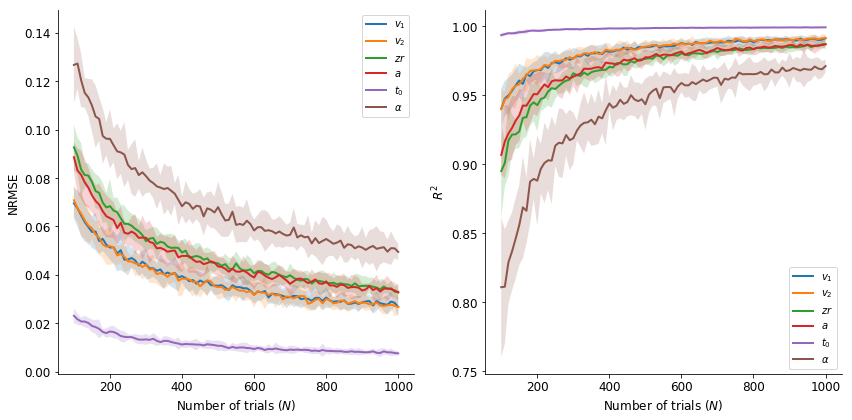

In [242]:
plot_performance_metrics(metrics, 
                         n_points_grid, 
                         param_names, 
                         legend_loc=['upper right', 'lower right'],
                         xlabel=r'Number of trials ($N$)', 
                         figsize=(12, 6),
                         filename='Levy_Metrics')

In [ ]:
pickle.dump(metrics, open('/results/metrics_levy.pkl', 'wb+'))

## Speed of inference

In [9]:
n_speed = 1000
X_test3, theta_test3 = simulate_diffusion(1000, parameter_bounds, n_points=1000)
X_test3, theta_test3 = transform(X_test3, theta_test3)

In [13]:
%timeit model.sample(X_test3, n_samples_posterior)

7.39 s ± 37.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# ABC-MMD Comparison

## ABC SMC with MMD summary

In [8]:
import pyabc
import os
import tempfile

In [151]:
def lfm_model(p, n_points=500):
    """
    Simulates LFM data for pyabc.
    """
    
    params = np.array([[p['v1'], p['v2'], 0.0, p['zr'], 0.0, p['a'], p['ndt'], 0.0, p['alpha']]])
    X = simulate_diffusion_params(params, to_tensor=True, n_points=500)[0].numpy()
    return {'data': X}

In [68]:
limits = dict(
    v1=(0, 6),
    v2=(-6, 6),
    zr=(0.3, 0.7),
    a=(0.6, 3.0),
    ndt=(0.3, 0.7),
    alpha=(1.0, 2.0)
)

prior = pyabc.Distribution(**{key: pyabc.RV('uniform', a, b - a) for key, (a,b) in limits.items()})

In [69]:
def distance(x, y):
    m1 = maximum_mean_discrepancy(x["data"][:, 0:1], 
                                  y["data"][:, 0:1]).numpy()
    m2 = maximum_mean_discrepancy(x["data"][:, 1:2], 
                                  y["data"][:, 1:2]).numpy()
    return m1 + m2

In [70]:
np.random.seed(42)
theta_true = np.array([[1.0, -2.0, 0.0, 0.6, 0.0, 1.4, 0.6, 0.0, 1.2]])
X_true = simulate_diffusion_params(theta_true, n_points=500)[0].numpy()
theta_true = theta_true[0, param_indices]
X_obs = {'data': X_true}

In [71]:
abc = pyabc.ABCSMC(lfm_model, prior, distance, population_size=2000)

In [72]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
abc.new(db_path, X_obs)

INFO:History:Start <ABCSMC(id=12, start_time=2020-02-28 00:32:10.087854, end_time=None)>


12

In [73]:
%%time
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:Epsilon:initial epsilon is 3.7794103622436466
INFO:ABC:t:0 eps:3.7794103622436466
INFO:ABC:t:1 eps:1.7822389602661106
INFO:ABC:t:2 eps:1.0671332134757594
INFO:ABC:t:3 eps:0.6689211561501456
INFO:ABC:t:4 eps:0.4695248488143743
INFO:ABC:t:5 eps:0.3473290393111402
INFO:ABC:t:6 eps:0.2629153633784623
INFO:ABC:t:7 eps:0.2022667532562953
INFO:ABC:t:8 eps:0.1597168704659671
INFO:ABC:t:9 eps:0.13004782566317005
INFO:History:Done <ABCSMC(id=12, start_time=2020-02-28 00:32:10.087854, end_time=2020-02-28 02:25:29.207961)>


Wall time: 1h 53min 3s


In [74]:
p = ['v1', 'v2', 'zr', 'a', 'ndt', 'alpha']
np.sum(df[p].values * w[:, np.newaxis], axis=0)
df, w = history.get_distribution()

In [154]:
abc_continued = pyabc.ABCSMC(lfm_model, prior, distance, population_size=2000)

In [155]:
abc_continued.load(db_path, 12)

12

In [156]:
%%time
history2 = abc_continued.run(minimum_epsilon=.01, max_nr_populations=10)

INFO:Epsilon:initial epsilon is 0.10796150706296541
INFO:ABC:t:10 eps:0.10796150706296541
INFO:ABC:t:11 eps:0.09213949423707833
INFO:ABC:t:12 eps:0.07898220691203292
INFO:ABC:t:13 eps:0.06875991821289062
INFO:ABC:t:14 eps:0.06138870583822051
INFO:ABC:t:15 eps:0.05531548387549065
INFO:ABC:t:16 eps:0.05033090790905589
INFO:ABC:t:17 eps:0.04617881774902344
INFO:ABC:t:18 eps:0.042825680522234455
INFO:ABC:t:19 eps:0.04044132109183812
INFO:History:Done <ABCSMC(id=12, start_time=2020-02-28 00:32:10.087854, end_time=2020-02-28 12:59:59.801778)>


Wall time: 3h 44min 38s


In [157]:
df, w = history2.get_distribution()

## BayesFlow samples

In [94]:
X_true_tensor = tf.convert_to_tensor(X_true[np.newaxis, :, :], dtype=tf.float32)

In [100]:
%%time
theta_samples_bf = model.sample(X_true_tensor, n_samples=2000, to_numpy=True)

Wall time: 69 ms


In [101]:
theta_samples_bf.mean(axis=0)

array([ 0.99573445, -2.2220614 ,  0.6178677 ,  1.483099  ,  0.59494054,
        1.2711464 ], dtype=float32)

In [108]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

def plot_joint(samples, param_names, filename=None, figsize=(10, 6)):
    """
    Plots joint recovery plots on the full test sample.
    """
    

    all_params = pd.DataFrame(samples, columns=param_names)

    g = sns.PairGrid(all_params)
    g.map_lower(sns.scatterplot, alpha=0.9)
    g.map_lower(corrfunc)
#     g.map_lower(sns.kdeplot, alpha=0.9)
    g.map_diag(sns.distplot, hist=True, hist_kws=dict(edgecolor="k", linewidth=1, alpha=0.9))
    g.fig.set_figwidth(figsize[0])
    g.fig.set_figheight(figsize[1])
    
    g.axes[0, 1].set_visible(False)
    
    if filename is not None:
        g.savefig('figures/wcst_joint_{}.png'.format(filename), dpi=600)

In [160]:
data = pd.concat([pd.DataFrame(theta_samples_bf, columns=param_names), 
                  pd.DataFrame(df[p].values , columns=param_names)], axis=0)

In [161]:
data['Method'] = np.append(np.array(['BayesFlow'] * 2000), np.array(['SMC-MMD'] * 2000))

In [158]:
theta_samples_abc = df[p].values

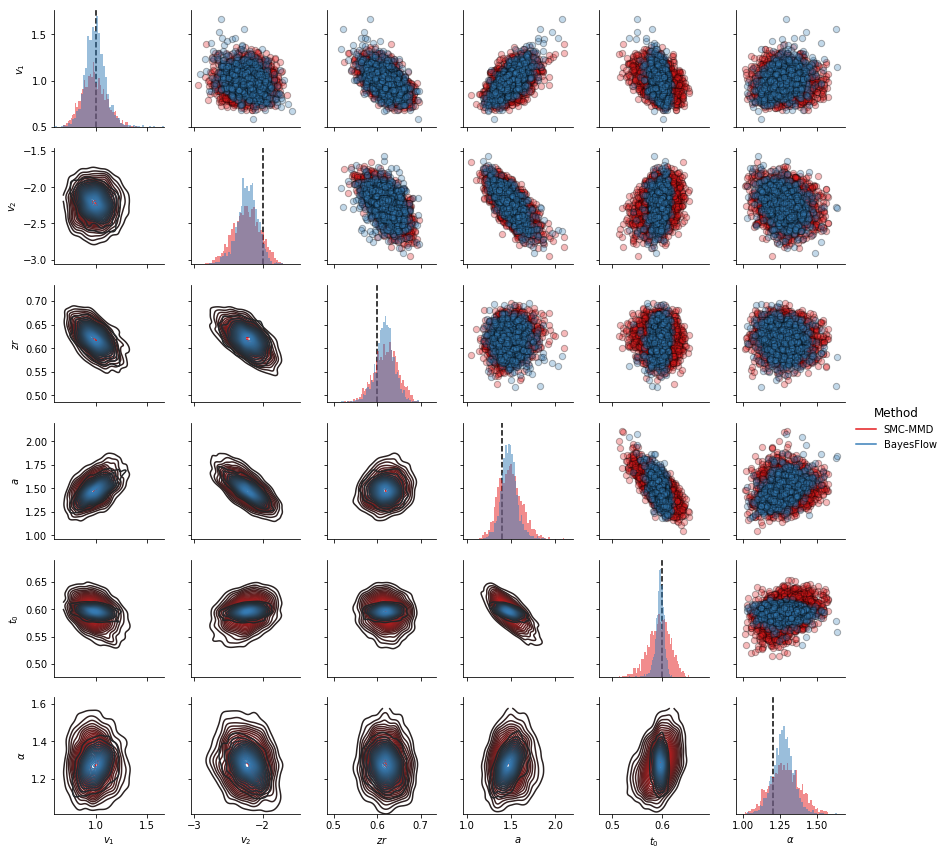

In [225]:
grid = sns.PairGrid(data, hue='Method', height = 2, palette='Set1', hue_order=['SMC-MMD', 'BayesFlow'])
grid = grid.map_upper(plt.scatter, alpha=0.3, s=40, edgecolor='k')
grid = grid.map_diag(plt.hist, bins = 50, alpha=0.5)
grid = grid.map_lower(sns.kdeplot, bw='silverman', n_levels=25, cut=0)
grid.add_legend()

for i in range(len(param_names)):
    grid.axes[i, i].axvline(theta_true[i], label='True', color='black', linestyle='dashed')

plt.setp(grid._legend.get_title(), fontsize=12)
plt.setp(grid._legend.get_texts(), fontsize=10)

grid.savefig("figures/pairs_levy.png", dpi=600)

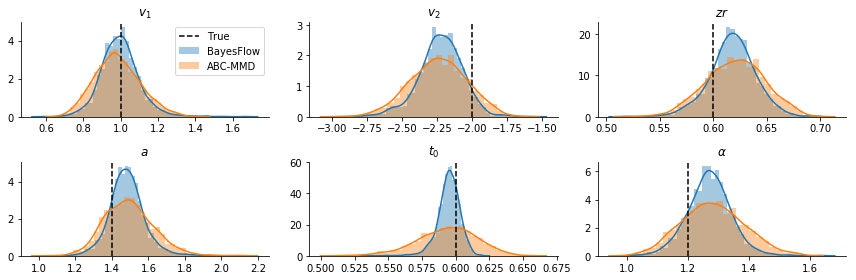

In [159]:
f, axarr = plt.subplots(2, 3, figsize=(12, 4))
for i, ax in enumerate(axarr.flat):
    sns.distplot(theta_samples_bf[:, i], ax=ax, label='BayesFlow')
    sns.distplot(theta_samples_abc[:, i], ax=ax, label='ABC-MMD')
    ax.axvline(theta_true[i], label='True', color='black', linestyle='dashed')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(param_names[i])
    
    if i == 0:
        ax.legend()
f.tight_layout()

In [224]:
pickle.dump(history2, open('results/abc_smc_run2.pkl', 'wb+'))